In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


```
../input
├── sample_submission.csv
├── test
│     ├── xxx.csv
│     └── xxx.csv
├── train
│     ├── xxx.csv
│     └── xxx.csv
└── train_meta.csv
```

In [ ]:
%%time

!cp /content/drive/MyDrive/python/cpt-mect/cpt-tutorial/input/data.zip .
!unzip data.zip -d input/

In [ ]:
!mkdir work
%cd work

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from glob import glob
from matplotlib import pyplot as plt

import seaborn as sns

import os, random, gc
import re, time, json
from  ast import literal_eval

import joblib

from  sklearn.model_selection  import StratifiedKFold

from IPython.display import Image, clear_output 

from sklearn.metrics import label_ranking_average_precision_score
from sklearn.preprocessing import LabelEncoder

from scipy.misc import derivative
from sklearn.metrics import precision_recall_curve, auc

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter('ignore')

import random
import lightgbm as lgb
import pickle

from glob import glob

from joblib import Parallel, delayed

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

sns.set(style="darkgrid")

In [ ]:
MODEL_CHECKPOINT_DIR = Path("/content/drive/MyDrive/python/cpt-mect/cpt-tutorial/baseline/")
ROOT_DIR = Path("/content/input/")

if not MODEL_CHECKPOINT_DIR.exists():
    MODEL_CHECKPOINT_DIR.mkdir()

In [ ]:
df_meta = pd.read_csv(Path(ROOT_DIR/ "train_meta.csv"))

center_csv_paths = [str(x) for x in list( ROOT_DIR.glob("train/*.csv") )]
files = [x.split("/")[-1] for x in center_csv_paths]

df_csv = pd.DataFrame({
    "filename":files,
    "filepath":center_csv_paths,
})

df_meta = pd.merge(df_meta,df_csv, on="filename", how="left")
df_meta

,filename,scratchpos_edge,scratchpos_center,scratchpos_baffle,filepath
0,000a849f.csv,NaN,NaN,NaN,/content/input/train/000a849f.csv
1,000bd931.csv,NaN,NaN,NaN,/content/input/train/000bd931.csv
2,001bd932.csv,NaN,NaN,15626 15668,/content/input/train/001bd932.csv
3,0029d521.csv,NaN,NaN,10937 10974,/content/input/train/0029d521.csv
4,00338f0c.csv,NaN,NaN,NaN,/content/input/train/00338f0c.csv
...,...,...,...,...,...
1421,ff037a09.csv,NaN,NaN,NaN,/content/input/train/ff037a09.csv
1422,ff9089ae.csv,NaN,NaN,NaN,/content/input/train/ff9089ae.csv
1423,ffac61bb.csv,6883 6981,NaN,NaN,/content/input/train/ffac61bb.csv
1424,ffea37c0.csv,NaN,NaN,9604 9630,/content/input/train/ffea37c0.csv


In [ ]:
# スペース区切りの傷位置アノテーションをintの配列に変更
# 傷1スタート、傷1エンド、傷2スタート、傷2エンド、、、というフォーマットなので配列のlenは必ず偶数になる
# 傷の個数をカウントしやすいように NaNを[]で置き換える
df_meta["scratchpos_edge"] = df_meta["scratchpos_edge"].apply( lambda x: [int(y) for y in x.split()] if not pd.isna(x) else [])
df_meta["scratchpos_center"] = df_meta["scratchpos_center"].apply( lambda x: [int(y) for y in x.split()] if not pd.isna(x) else [])
df_meta["scratchpos_baffle"] = df_meta["scratchpos_baffle"].apply( lambda x: [int(y) for y in x.split()] if not pd.isna(x) else [])

df_meta["num_edge"] = df_meta["scratchpos_edge"].apply( lambda x: int(len(x) / 2))
df_meta["num_center"] = df_meta["scratchpos_center"].apply( lambda x: int(len(x) / 2))
df_meta["num_baffle"] = df_meta["scratchpos_baffle"].apply( lambda x: int(len(x) / 2))

df_meta["num_all"] = df_meta["num_edge"] + df_meta["num_center"] + df_meta["num_baffle"]

def merge_scratch(row):
    
    merged_pos = row["scratchpos_edge"] + row["scratchpos_center"] + row["scratchpos_baffle"]
    merged_pos.sort()

    return merged_pos

df_meta["scratchpos_all"] = df_meta.apply(merge_scratch, axis=1)
df_meta

,filename,scratchpos_edge,scratchpos_center,scratchpos_baffle,filepath,num_edge,num_center,num_baffle,num_all,scratchpos_all
0,000a849f.csv,[],[],[],/content/input/train/000a849f.csv,0,0,0,0,[]
1,000bd931.csv,[],[],[],/content/input/train/000bd931.csv,0,0,0,0,[]
2,001bd932.csv,[],[],"[15626, 15668]",/content/input/train/001bd932.csv,0,0,1,1,"[15626, 15668]"
3,0029d521.csv,[],[],"[10937, 10974]",/content/input/train/0029d521.csv,0,0,1,1,"[10937, 10974]"
4,00338f0c.csv,[],[],[],/content/input/train/00338f0c.csv,0,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...
1421,ff037a09.csv,[],[],[],/content/input/train/ff037a09.csv,0,0,0,0,[]
1422,ff9089ae.csv,[],[],[],/content/input/train/ff9089ae.csv,0,0,0,0,[]
1423,ffac61bb.csv,"[6883, 6981]",[],[],/content/input/train/ffac61bb.csv,1,0,0,1,"[6883, 6981]"
1424,ffea37c0.csv,[],[],"[9604, 9630]",/content/input/train/ffea37c0.csv,0,0,1,1,"[9604, 9630]"


## スペクトルデータについて
* 熱交換器の伝熱管にセンサーを通してスペクトルデータをサンプリング(サンプリング0.1sec間隔)
* 伝熱管にセンサーを通す際に、入り口付近、出口付近には値が大きく振れてしまう管端信号が発生する。
* バッフルプレート付近ではF2信号を確認すると一定間隔で波が発生する。
* 管端信号の発生箇所を管端部、バッフルプレート付近をバッフル部、それ以外を管中央部として定義している。

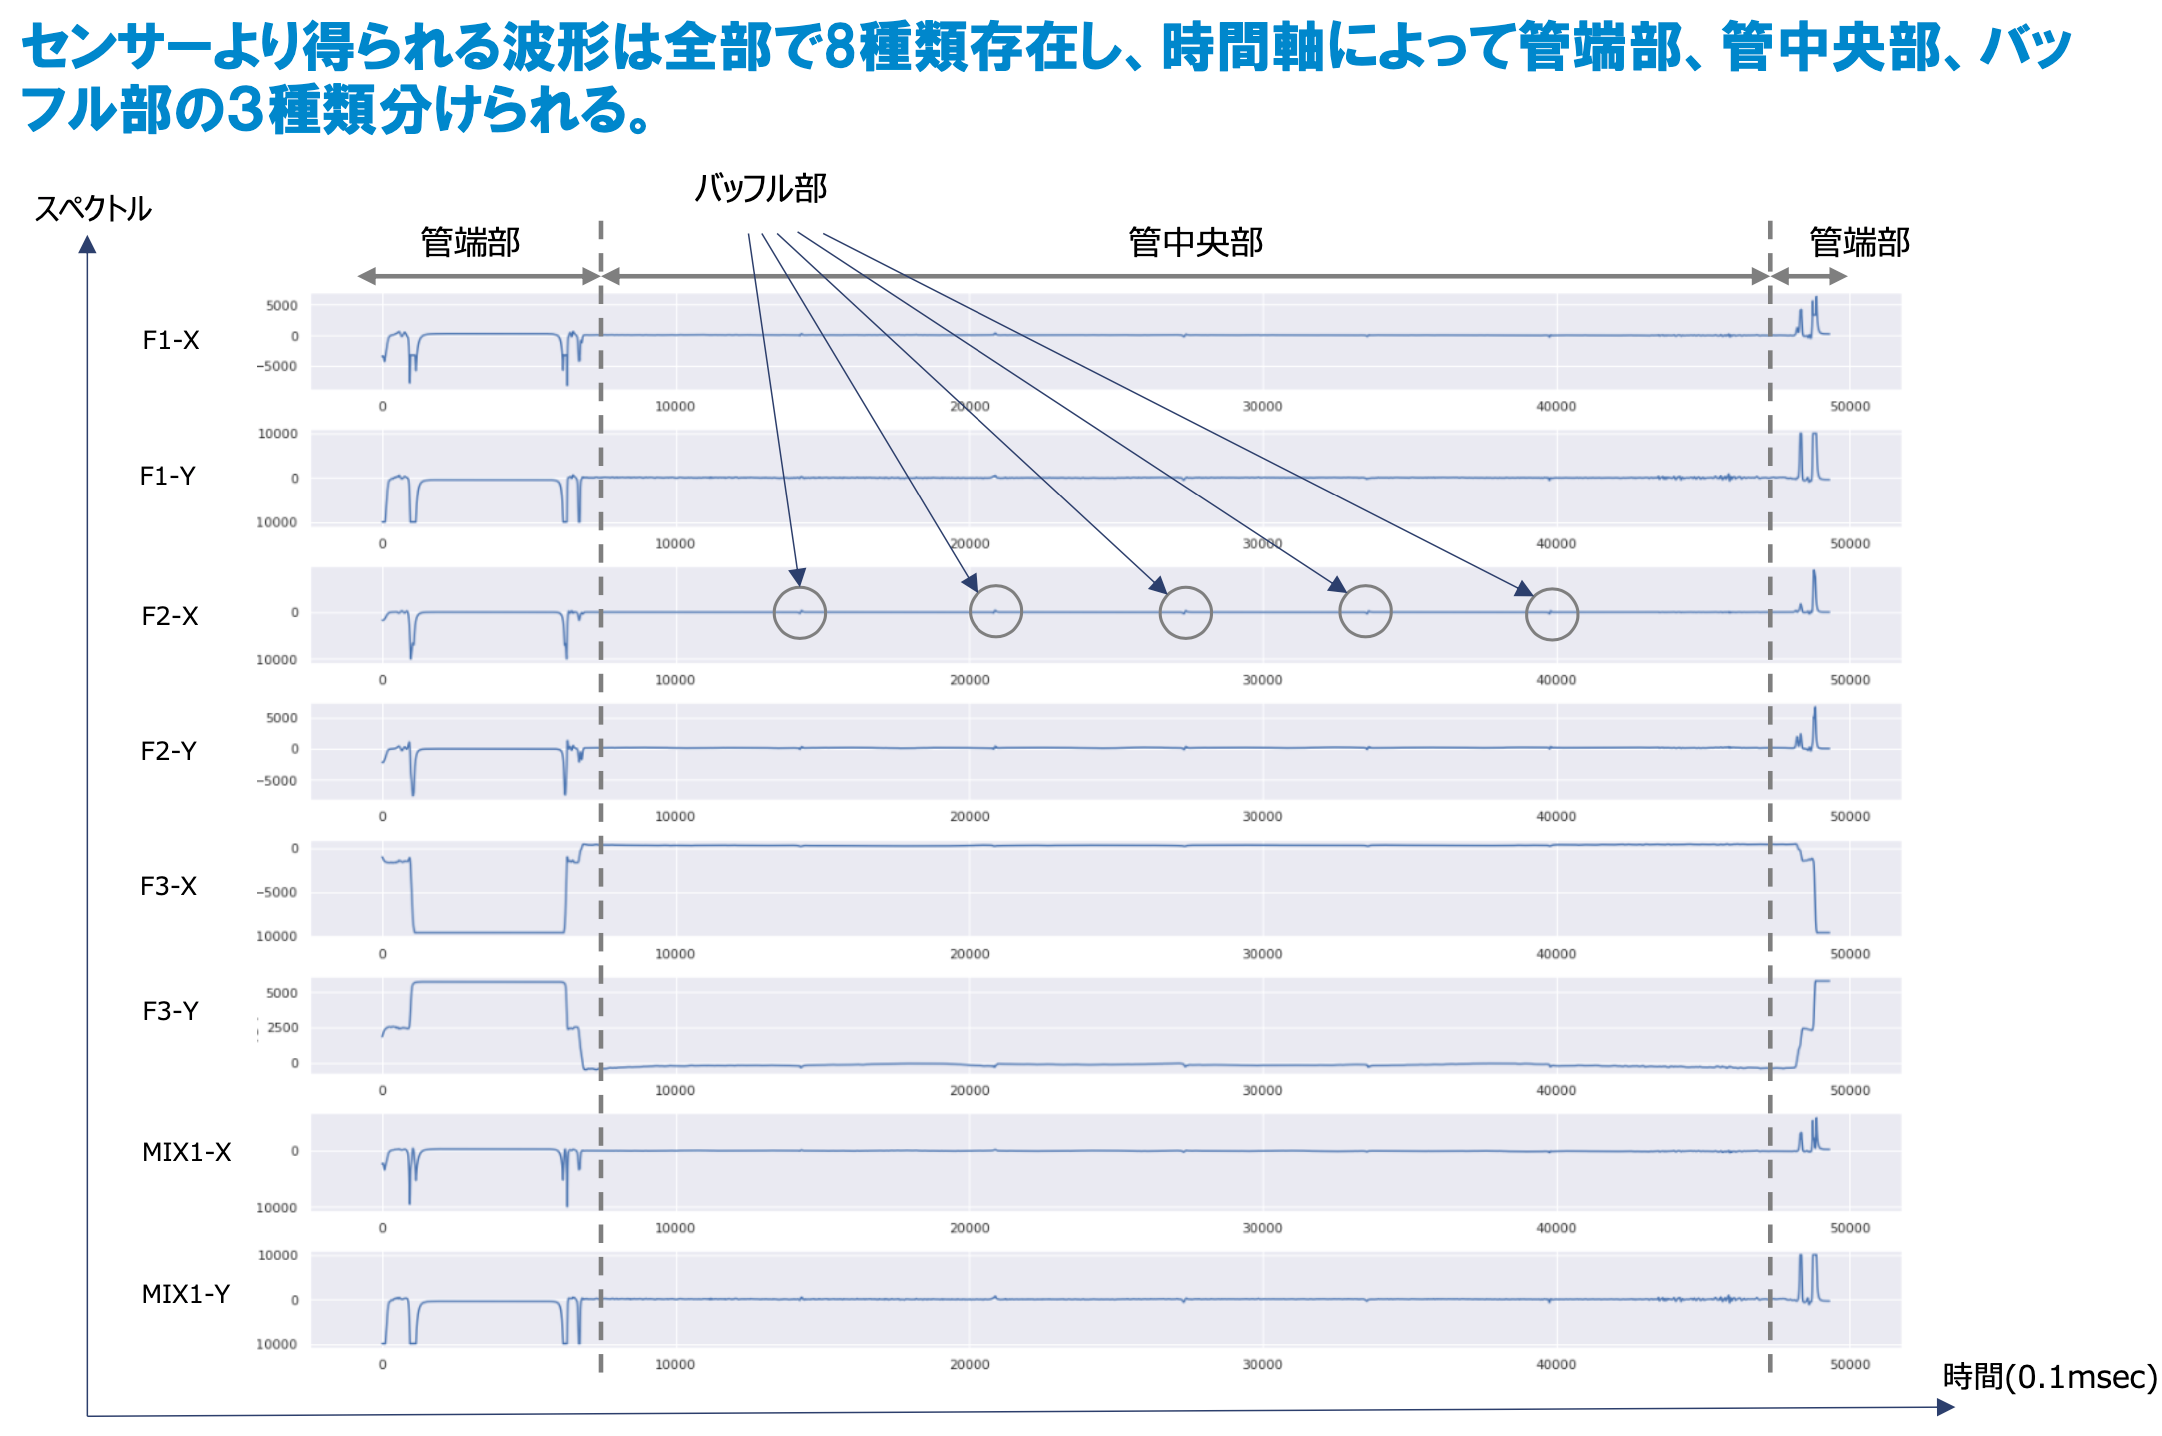

## 傷位置の可視化
バッフル信号がわかりやすいF2-Xとバッフルの影響を取り除いたMIX-Yを描画し、  
赤：管端部、青：管中央部、緑：バッフルで傷の箇所を塗りつぶす  


In [ ]:
def plot_waves(df_, len_=20, s=0, figsize=(20,24), lim=(-1000,1000)):
    """
    バッフルの影響を取り除いた信号(MIX1-Y)、バッフル信号あり(F2-Y)の可視化

    Parameters
    --------------
    df_ : DataFrame
        スペクトルデータ
    scratch : list
        傷アノテーション
    figsize : tuple
        figsize
    lim : tuple
        y軸の描画領域

    Returns
    ----------
    None
    """

    target = "MIX1-Y"
    target2 = "F2-Y"
    paths = df_.loc[s:s+len_ , "filepath"].values

    plt.figure(figsize=figsize)

    c_ls = ["red","blue","green"]

    for i,path in enumerate(paths):

        df = pd.read_csv(path)
        plt.subplot(len(paths), 1, i+1)

        g = sns.lineplot(data=df[:],x=df.index[:],y=target)
        g1 = sns.lineplot(data=df[:],x=df.index[:],y=target2)

        scratchs_edge = df_.loc[s+i , "scratchpos_edge"]
        scratchpos_center = df_.loc[s+i , "scratchpos_center"]
        scratchpos_baffle = df_.loc[s+i , "scratchpos_baffle"]
        s_ls = [scratchs_edge,scratchpos_center,scratchpos_baffle]

        for scratch, color in zip(s_ls,c_ls):
            if len(scratch) > 0:
                s_scratch = scratch[0::2]
                e_scratch = scratch[1::2]

                for s_,e_ in zip(s_scratch, e_scratch):
                    plt.axvspan(s_, e_, linewidth=5,color=color,alpha=0.9)
        
        plt.title(path.split("/")[-1])
        plt.ylim(lim)

    plt.tight_layout()
    plt.show()

def plot_each_wave(df_, id ,figsize=(20,24), lim=(-1000,1000)):
    """
    Parameters
    --------------
    df_ : DataFrame
        スペクトルデータ
    scratch : list
        傷アノテーション
    figsize : tuple
        figsize
    lim : tuple
        y軸の描画領域

    Returns
    ----------
    None
    """

    path = df_.loc[id, "filepath"]
    df = pd.read_csv(path)

    plt.figure(figsize=figsize)

    c_ls = ["red","blue","green"]

    cols = df.columns

    for i,target in enumerate(cols):
        
        plt.subplot(len(cols), 1, i+1)
        g = sns.lineplot(data=df[:],x=df.index[:],y=target)

        scratchs_edge = df_.loc[id , "scratchpos_edge"]
        scratchpos_center = df_.loc[id , "scratchpos_center"]
        scratchpos_baffle = df_.loc[id , "scratchpos_baffle"]
        s_ls = [scratchs_edge,scratchpos_center,scratchpos_baffle]

        for scratch, color in zip(s_ls,c_ls):
            if len(scratch) > 0:
                s_scratch = scratch[0::2]
                e_scratch = scratch[1::2]

                for s_,e_ in zip(s_scratch, e_scratch):
                    plt.axvspan(s_, e_, linewidth=5,color=color,alpha=0.9)
                    #plt.axvspan(s_, e_, linestyle=':',linewidth=2,alpha=0.8)
        
        plt.title(target)
        plt.ylim(lim)

    plt.tight_layout()
    plt.show()


def get_center_ids(df_, target="MIX1-Y",  th=7500, margin=1000):
    """
    管端部、管中央部の境目のidを取得する。 管端部は入り口、出口と2つあるので、2つの境目を取得。
    ※管端部、管中央部の境目の明確な定義は存在せず、Trainデータを可視化して目視でルールを決定した
    
    管端部の検出用の大きい閾値と、管中央部の最大値程度の小さい閾値の2種類使って判定を行う。

    Parameters
    --------------
    df_ : DataFrame
        スペクトルデータ
    target : str
        DataFrameのcolumns名
    th : int
        管端部の検出用の閾値
    margin : int
        管端部の検出用の閾値から、margin分管端部領域を拡大する。

    Returns
    ----------
    s_center : int
        管中央部の開始位置
    e_center : int
        管中央部の終了位置
    """
    harf_pos = int(len(df_)/2)
    
    first_th = -th
    last_th = th

    df_first = df_[:harf_pos]
    first_ids = df_first[df_first[target]< first_th].index
    

    first_max = first_ids.max()
    
    s_center = first_max + margin

    df_last = df_[harf_pos:]
    last_ids = df_last[df_last[target]> last_th].index
    
    last_min = last_ids.min()
    
    e_center = last_min - margin
    
    if len(first_ids) == 0:
        s_center = 0
    
    if len(last_ids) == 0:
        e_center = len(df_) -1

    return s_center, e_center

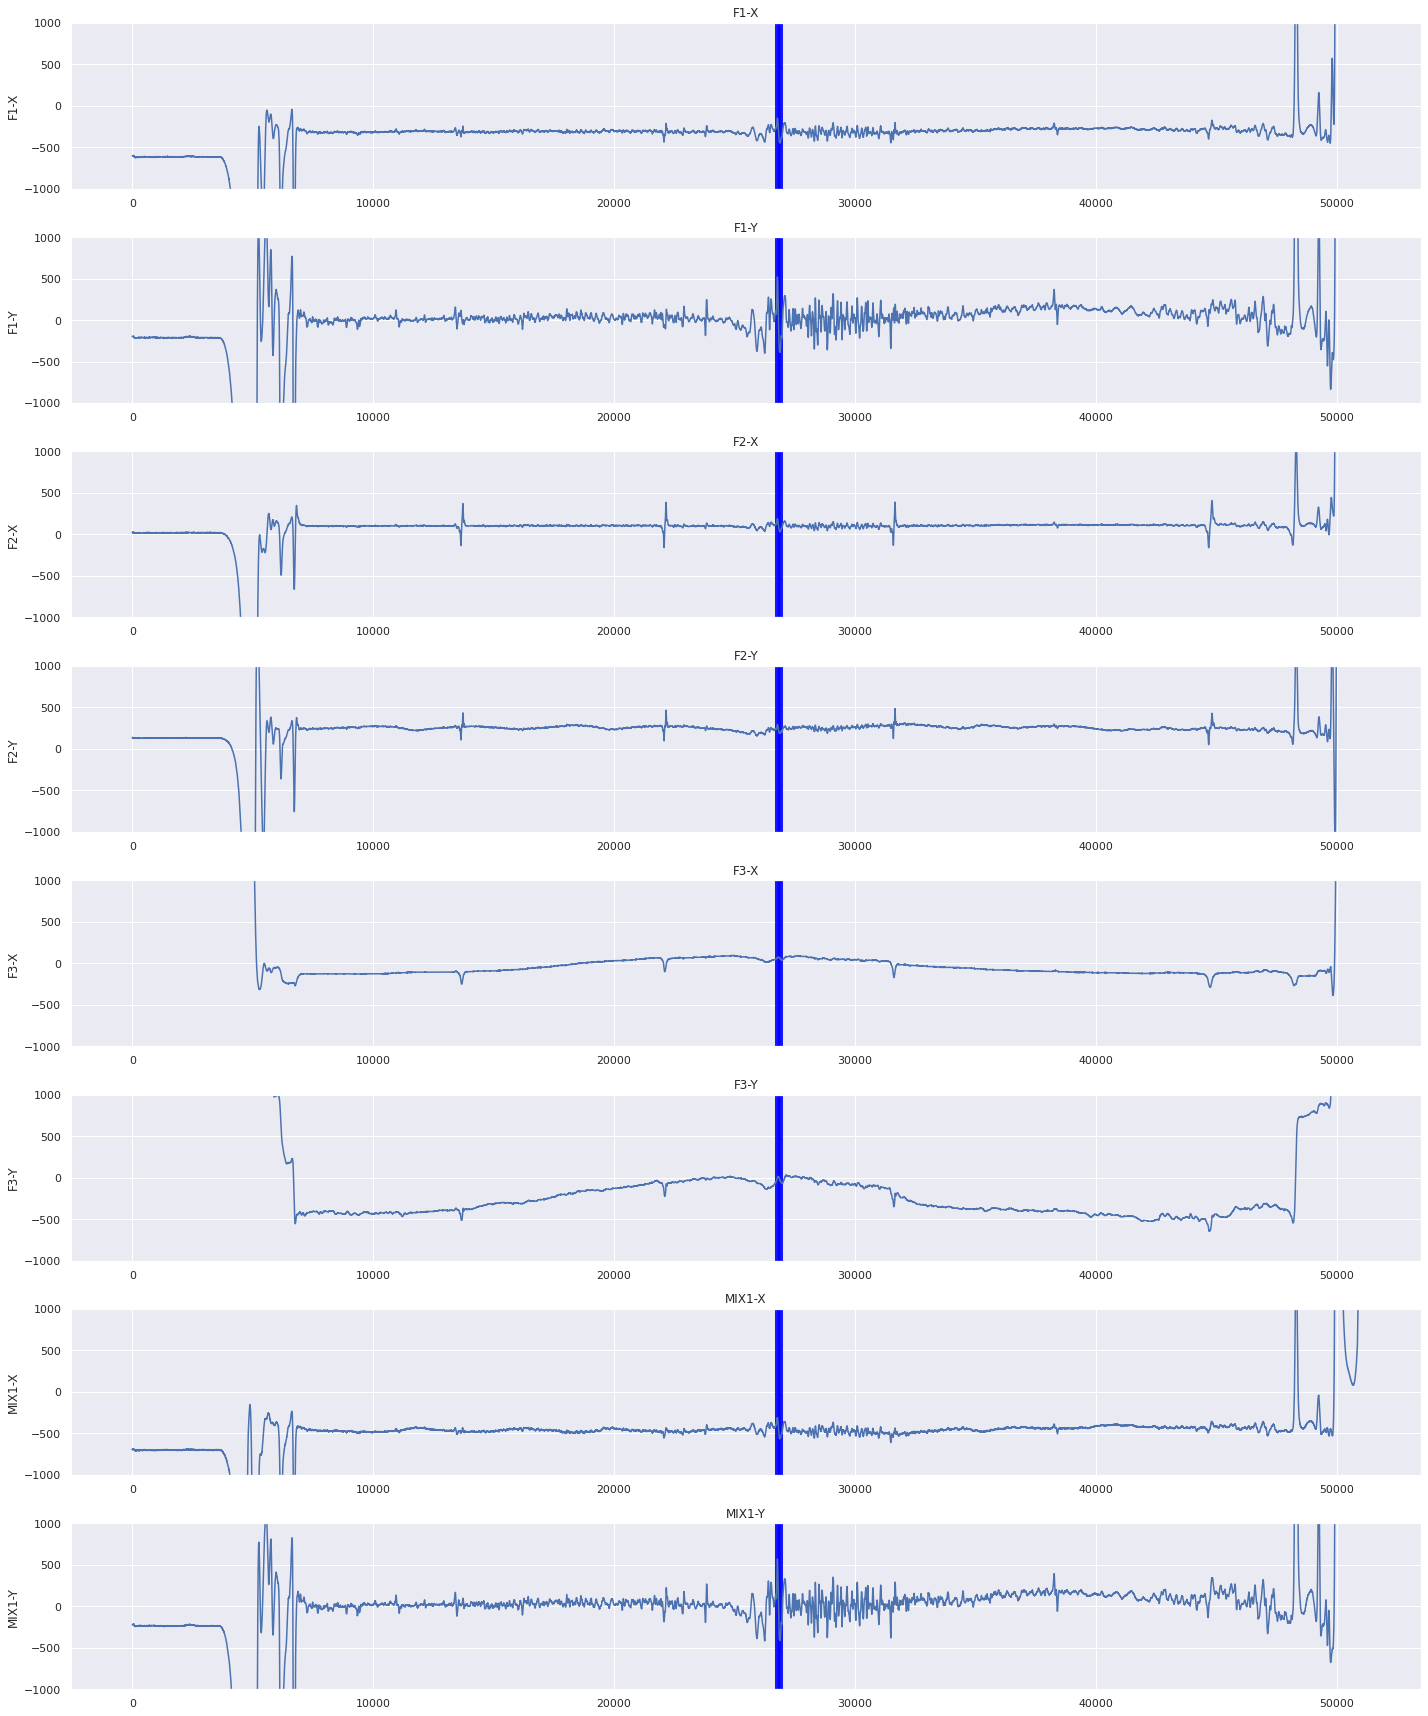

In [ ]:
df_meta_center = df_meta[(df_meta["num_edge"] >0) | (df_meta["num_center"] >0)].reset_index(drop=True)
plot_each_wave(df_meta_center, 0 ,figsize=(20,24), lim=(-1000,1000))

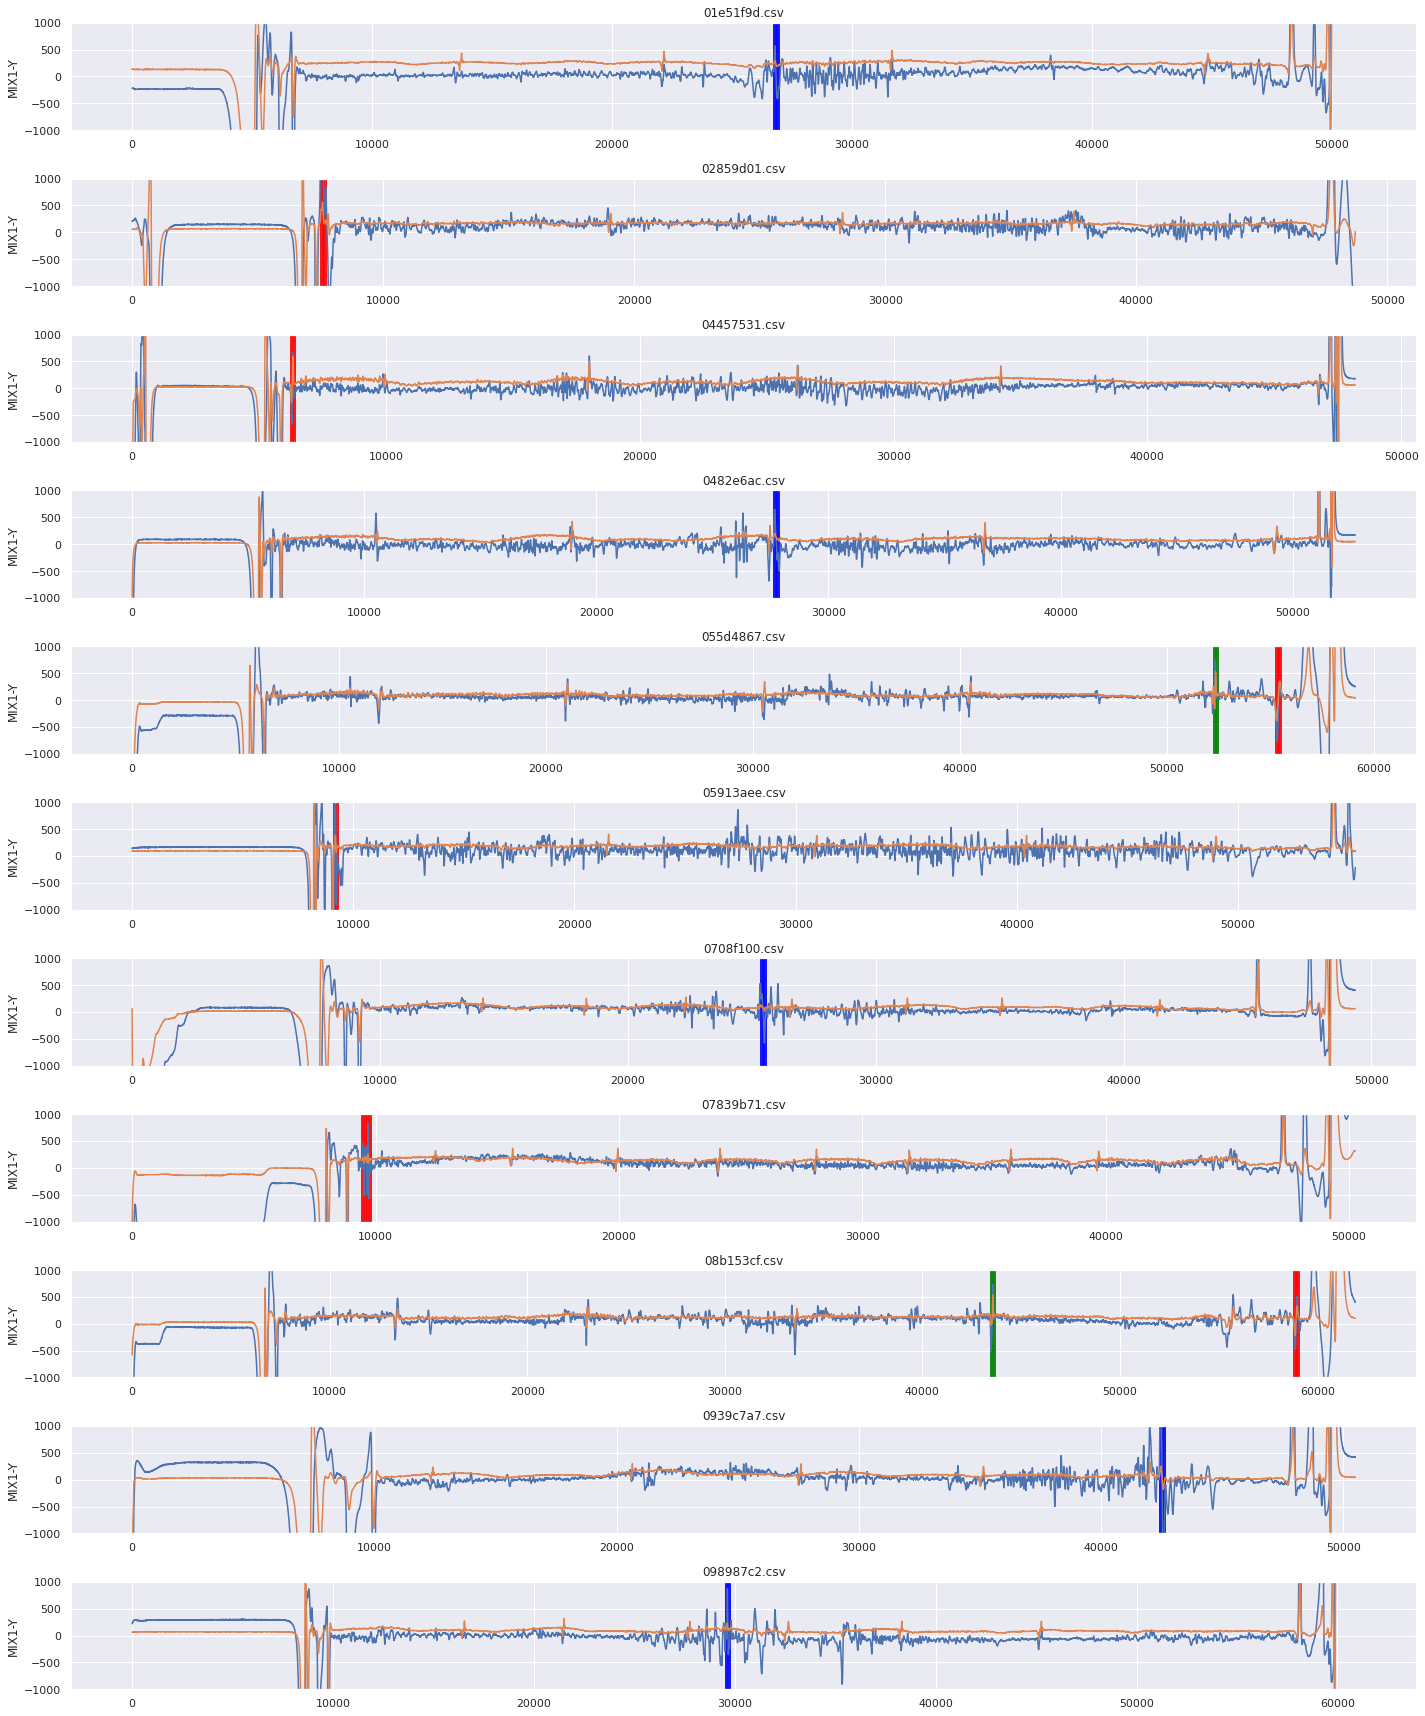

In [ ]:
plot_waves(df_meta_center, len_=10, s=0)

### CV
* 傷の合計数でStratifiedKFold

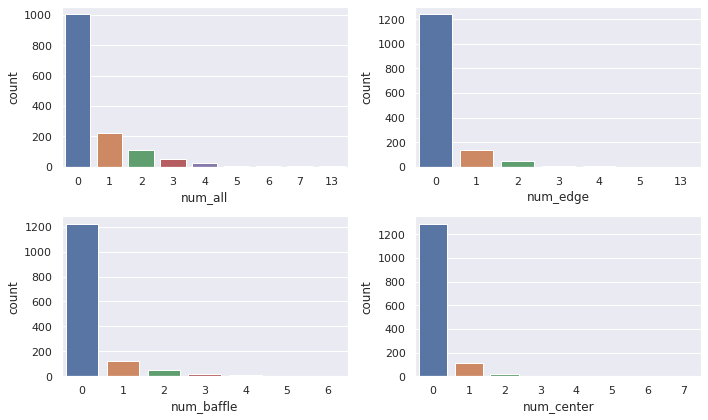

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
g = sns.countplot(df_meta["num_all"][:])
plt.subplot(2,2,2)
g = sns.countplot(df_meta["num_edge"][:])
plt.subplot(2,2,3)
g = sns.countplot(df_meta["num_baffle"][:])
plt.subplot(2,2,4)
g = sns.countplot(df_meta["num_center"][:])

plt.tight_layout()
plt.show()

In [ ]:
folds = [0,1,2,3]
target_col = "num_all"
df_meta["fold"] = -1
kf = StratifiedKFold(n_splits=len(folds), random_state=42, shuffle=True)

for i, (_, idx) in enumerate(kf.split(df_meta, df_meta[target_col])):
    df_meta.loc[idx, "fold"] = i

df_meta.groupby("fold")[["num_edge","num_center","num_baffle", "num_all"]].sum()

,num_edge,num_center,num_baffle,num_all
fold,,,,
0,58,50,87,195
1,57,44,94,195
2,71,46,73,190
3,72,46,82,200


In [ ]:
def set_seed(seed=220824):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"]=str(seed)

In [ ]:
def get_lgbdatasets(df_):
    """
    lightGBMで学習を行うために、スペクトルcsvを縦にconcatする。傷なし:0. 傷あり:1としてtargetカラムを作る

    Parameters
    --------------
    df_ : DataFrame
        メタデータ

    Returns
    ----------
    df
    """

    paths = df_["filepath"].values
    scratches = df_["scratchpos_all"].values

    window = 100

    dfs = []

    tq_ = tqdm(zip(paths,scratches), total=len(paths))
    for i, (path, scratch) in enumerate(tq_):

        df = pd.read_csv(path)
        s, e = get_center_ids(df, margin=0)
        df = df[s:e]

        df['MIX1-X-std'] = df['MIX1-X'].rolling(window).std()
        df['MIX1-Y-std'] = df['MIX1-Y'].rolling(window).std()

        s_scratch = scratch[0::2]
        e_scratch = scratch[1::2]

        df["target"] = 0

        for s,e in zip(s_scratch, e_scratch):
            df.loc[s:e+1, "target"] = 1

        dfs.append(df)
    
    df = pd.concat(dfs, axis=0)

    del dfs
    gc.collect()

    return df

In [ ]:
def get_score(y_true, y_pred):
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    score = metrics.auc(recall, precision)
    return score

In [ ]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	def fl(x,t):
		p = 1/(1+np.exp(-x))
		return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
	partial_fl = lambda x: fl(x, y_true)
	grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
	hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
	return grad, hess

focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 1.)

In [ ]:
def valid_fn(valid_folds, model):

    filepaths = valid_folds["filepath"].values
    filenames = valid_folds["filename"].values
    scratches = valid_folds["scratchpos_all"].values
    window = 50
    mmscaler = MinMaxScaler()

    tq_ = tqdm(zip(filepaths,filenames,scratches), total=len(filepaths))
    for i,(path,name,scratch) in enumerate(tq_):
        
        valid = pd.read_csv(path)
        
        name = name[:-4]
        
        valid['MIX1-X-std'] = valid['MIX1-X'].rolling(window).std()
        valid['MIX1-Y-std'] = valid['MIX1-Y'].rolling(window).std()

        valid["target"] = 0
        s_scratchs = scratch[0::2]
        e_scratchs = scratch[1::2]
        for s_scratch,e_scratch in zip(s_scratchs, e_scratchs):
            valid.loc[s_scratch:e_scratch+1, "target"] = 1

        pred = model.predict(valid.drop("target", axis=1))

        # predictがマイナスの値になることがあるため0-1の範囲に収める
        pred = mmscaler.fit_transform(pred[:,np.newaxis])
        pred = pred.reshape(-1)
        
        # postprocess
        # 細管の出入り口の大きく値が振れている箇所はアノテーションがないので予測を0に落とす
        s, e = get_center_ids(valid, margin=0)

        pred[:s] = 0
        pred[e:] = 0

        target = valid["target"].values
        
        num_50 = int(len(pred)/50)
        sub_pred = [pred[50*x:50*(x+1)].max() for x in range(num_50)]
        sub_target = [target[50*x:50*(x+1)].max() for x in range(num_50)]

        if i==0:
            preds = pred
            targets = target

            sub_preds = sub_pred
            sub_targets = sub_target

        else:
            preds = np.append(preds, pred)
            targets = np.append(targets, target)
            
            sub_preds = np.append(sub_preds, sub_pred)
            sub_targets = np.append(sub_targets, sub_target)

    return get_score(targets, preds), get_score(sub_targets, sub_preds)

In [ ]:
RANDOM_STATE = 220824
TARGET_COL = "target"

params = {
    'bagging_freq': 7,
    'boosting_type': 'gbdt',
    'class_weight': 'balanced',
    "num_leaves": 512,
    "learning_rate": 0.01,
    'max_depth': 10,
    'metric': 'pr_auc',
    'n_estimators': 1000,
    'objective': 'binary',
    'random_state': RANDOM_STATE,
    'task': 'train',
}

scores = []
score_subs = []

for fold in folds:
    
    print(f" ===== fold {fold} =====")
    train_folds = df_meta[df_meta['fold'] != fold].reset_index(drop=True)
    valid_folds = df_meta[df_meta['fold'] == fold].reset_index(drop=True)

    # Undersamping for Imbalanced data
    train_folds = train_folds[(train_folds["num_edge"] >0) | (train_folds["num_center"] >0) | (train_folds["num_baffle"] >0)].reset_index(drop=True)

    train = get_lgbdatasets(train_folds)
    X_train, y_train = train.drop(TARGET_COL, axis=1), train[TARGET_COL]

    set_seed(RANDOM_STATE)

    lgb_train = lgb.Dataset(X_train, y_train)
    model = lgb.train(
        params,
        lgb_train,
        fobj=focal_loss,
        verbose_eval = -1,
        num_boost_round=100,
    )

    pickle.dump(model, open(str(MODEL_CHECKPOINT_DIR)+"/LGBM_"+str(fold).zfill(2)+".pkl", "wb"))

    score, score_sub = valid_fn(valid_folds, model)

    print(f"fold{fold} score : {score}")
    print(f"fold{fold} submission format score : {score_sub}")
    scores.append(score)
    score_subs.append(score_sub)

    del train
    gc.collect()

    break

score = np.array(score).mean()
score_sub = np.array(score_subs).mean()
print(f"cv : {score}")
print(f"cv submission format : {score_sub}")

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

## Inference

### submissionフォーマットについて
スペクトルデータに対して50区間に傷があるかの確率を予測するタスクですが、最後の箇所は切り捨てております。   
319f7d45_50は 319f7d45.csvの 0-49が該当箇所となります。   
319f7d45.csvのlenは50422だが、319f7d45_50400までの予測で最後の50400-50422はsubmissionフォーマットには含まれません。  

In [ ]:

for fold in folds:
    
    model = pickle.load(open(str(MODEL_CHECKPOINT_DIR)+"/LGBM_"+str(fold).zfill(2)+".pkl", "rb"))

    break

In [ ]:
csv_paths = [str(x) for x in list( ROOT_DIR.glob("test/*.csv") )]
files = [x.split("/")[-1] for x in csv_paths]

test_csv = pd.DataFrame({
    "filename":files,
    "filepath":csv_paths,
})

In [ ]:
sample_submission = pd.read_csv(f"{str(ROOT_DIR)}/sample_submission.csv")

In [ ]:
filepaths = test_csv["filepath"].values
filenames = test_csv["filename"].values
window = 50

sub_preds=[]
sub_ids=[]
mmscaler = MinMaxScaler()

tq_ = tqdm(zip(filepaths,filenames), total=len(filepaths))

for path,name in tq_:
    
    test = pd.read_csv(path)
    name = name[:-4]
    
    test['MIX1-X-std'] = test['MIX1-X'].rolling(window).std()
    test['MIX1-Y-std'] = test['MIX1-Y'].rolling(window).std()

    test_pred = model.predict(test)
    test_pred = mmscaler.fit_transform(test_pred[:,np.newaxis])
    test_pred = test_pred.reshape(-1)

    s, e = get_center_ids(test, margin=0)
    
    test_pred[:s] = 0
    test_pred[e:] = 0

    #num_50 = int(len(test_pred)/50)
    num_50 = len(sample_submission[sample_submission["id"].str.contains(name)])

    sub_ids = sub_ids + [name+ "_" +str(50*(x+1)) for x in range(num_50)]
    sub_preds = sub_preds + [test_pred[50*x:50*(x+1)].max() for x in range(num_50)]


  0%|          | 0/1458 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame({
    "id":sub_ids,
    "target":sub_preds
})

submission.to_csv(f"{str(MODEL_CHECKPOINT_DIR)}/submission.csv" ,index=False)

### EOF